In [110]:
import pandas as pd

In [111]:
wc_game_stats = pd.read_csv('Data/Fifa_world_cup_matches.csv')
wc_game_stats = wc_game_stats.drop(columns=['hour', 'date', 'category'], axis=1)
wc_game_stats.head()

,team1,team2,possession team1,possession team2,possession in contest,number of goals team1,number of goals team2,total attempts team1,total attempts team2,conceded team1,...,penalties scored team1,penalties scored team2,goal preventions team1,goal preventions team2,own goals team1,own goals team2,forced turnovers team1,forced turnovers team2,defensive pressures applied team1,defensive pressures applied team2
0,QATAR,ECUADOR,42%,50%,8%,0,2,5,6,2,...,0,1,6,5,0,0,52,72,256,279
1,ENGLAND,IRAN,72%,19%,9%,6,2,13,8,2,...,0,1,8,13,0,0,63,72,139,416
2,SENEGAL,NETHERLANDS,44%,45%,11%,0,2,14,9,2,...,0,0,9,15,0,0,63,73,263,251
3,UNITED STATES,WALES,51%,39%,10%,1,1,6,7,1,...,0,1,7,7,0,0,81,72,242,292
4,ARGENTINA,SAUDI ARABIA,64%,24%,12%,1,2,14,3,2,...,1,0,4,14,0,0,65,80,163,361


In [112]:
wc_game_stats.columns = wc_game_stats.columns.str.strip()
wc_game_stats['team1']

0             QATAR
1           ENGLAND
2           SENEGAL
3     UNITED STATES
4         ARGENTINA
          ...      
59          ENGLAND
60        ARGENTINA
61           FRANCE
62          CROATIA
63        ARGENTINA
Name: team1, Length: 64, dtype: object

In [113]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
wc_game_stats['team1'] = encoder.fit_transform(wc_game_stats['team1'])
wc_game_stats['team2'] = encoder.fit_transform(wc_game_stats['team2'])


In [114]:
wc_game_stats['match_result'] = wc_game_stats['number of goals team1'] > wc_game_stats['number of goals team2']


In [115]:
wc_game_stats['possession team1'] = wc_game_stats['possession team1'].astype(str)
wc_game_stats['possession team2'] = wc_game_stats['possession team2'].astype(str)
wc_game_stats['possession team1'] = wc_game_stats['possession team1'].str.rstrip('%').astype(float) / 100
wc_game_stats['possession team2'] = wc_game_stats['possession team2'].str.rstrip('%').astype(float) / 100

features = wc_game_stats[['possession team1', 'possession team2', 'total attempts team1', 
                          'total attempts team2', 'goal preventions team1', 'goal preventions team2']]
target = wc_game_stats['match_result']


In [116]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (
                features,
                target,
                test_size=0.2,
                train_size=0.8,
                random_state= 2
)

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim

class FootballPredictionModel(nn.Module):
    def __init__(self, input_size):
        super(FootballPredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  
        self.fc2 = nn.Linear(64, 32)  
        self.fc3 = nn.Linear(32, 1)  
        self.sigmoid = nn.Sigmoid()  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

input_size = X_train.shape[1]
model = FootballPredictionModel(input_size)


In [119]:
loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [120]:
num_epochs = 1000

for epochs in range(num_epochs):
    inputs = torch.tensor(X_train.values, dtype=torch.float32)
    labels = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

    prediction = model(inputs)
    BCE = loss(prediction, labels)

    BCE.backward()
    optimizer.step()
    optimizer.zero_grad()

    if(epochs + 1) % 100 == 0:
        print(f"Epoch {epochs + 1}/{num_epochs}, BCE: {BCE.item()} ")

Epoch 100/1000, BCE: 0.5964484214782715 
Epoch 200/1000, BCE: 0.48429736495018005 
Epoch 300/1000, BCE: 0.4026091694831848 
Epoch 400/1000, BCE: 0.37128496170043945 
Epoch 500/1000, BCE: 0.3480484187602997 
Epoch 600/1000, BCE: 0.3267176151275635 
Epoch 700/1000, BCE: 0.3038678765296936 
Epoch 800/1000, BCE: 0.2804920971393585 
Epoch 900/1000, BCE: 0.26034805178642273 
Epoch 1000/1000, BCE: 0.24396514892578125 


In [121]:
model.eval()
test_inputs = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


with torch.no_grad():
    test_predictions = model(test_inputs)

# Convert predictions to class labels (0 or 1)
predicted_classes = (test_predictions > 0.5).int()
accuracy = (predicted_classes == test_labels).float().mean()
print(f'Accuracy: {accuracy.item():.4f}')

Accuracy: 0.6923


In [122]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predicted_classes)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[4 2]
 [2 5]]


In [123]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(test_labels, predicted_classes)
recall = recall_score(test_labels, predicted_classes)
f1 = f1_score(test_labels, predicted_classes)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Precision: 0.7143, Recall: 0.7143, F1 Score: 0.7143


In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()

parameters = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20]}

grid_search = GridSearchCV(estimator=model, param_grid=parameters)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


c:\Users\rgonz\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 5, 'n_estimators': 100}


In [128]:
torch.save(model, 'futbol_model.pth') 


In [140]:
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.nn as nn
import torch.optim as optim

class PyTorchModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size, learning_rate=0.001, epochs=100):
        # Initialize the PyTorch model
        self.input_size = input_size
        self.model = FutbolPredictionModel(input_size)  # Assuming you already defined FutbolPredictionModel
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    def fit(self, X, y):
        # Convert the training data to PyTorch tensors
        inputs = torch.tensor(X.values, dtype=torch.float32)
        labels = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
        
        # Training loop
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()  # Zero the gradients
            outputs = self.model(inputs)  # Get model outputs
            loss = self.criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagate
            self.optimizer.step()  # Update the model weights
        
        return self

    def predict(self, X):
        # Convert the test data to PyTorch tensor
        inputs = torch.tensor(X.values, dtype=torch.float32)
        
        # Get predictions
        with torch.no_grad():  # Disable gradient calculation
            outputs = self.model(inputs)
        
        # Convert logits to binary predictions
        predictions = (outputs > 0.5).int()
        return predictions.numpy()  # Convert to NumPy array for compatibility

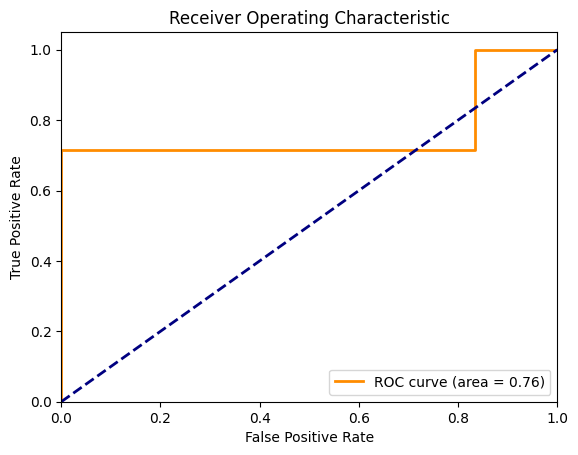

In [142]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
